In [49]:
from window_generator import WindowGenerator
import numpy as np
import pandas as pd
import kerastuner as kt
from fredapi import Fred
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler

import math
import keras
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import save_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from kerastuner.tuners import RandomSearch
import tensorflow as tf
from kerastuner.engine.hyperparameters import HyperParameters
import warnings
warnings.simplefilter("ignore", UserWarning)

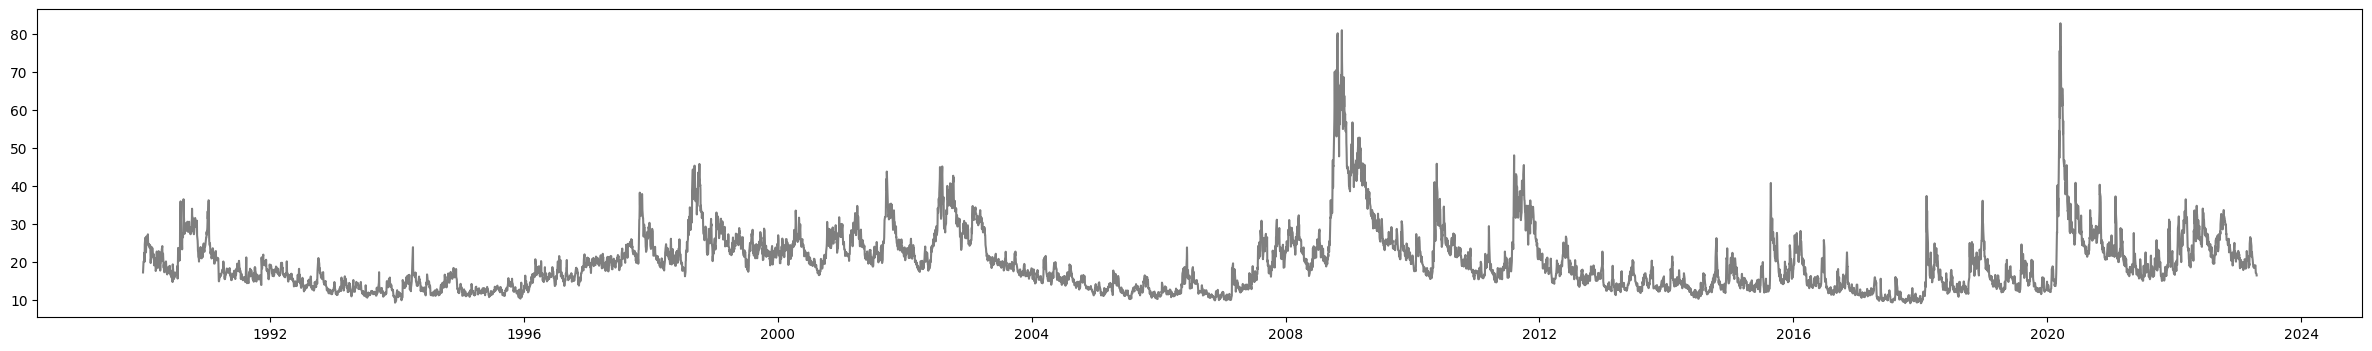

In [50]:
FRED_API_KEY = "29b81578246f3b1d8661dfdb956124ba"
fred = Fred(api_key=FRED_API_KEY)
VIX = fred.get_series('VIXCLS')
VIX = pd.DataFrame(VIX, columns=['VIX'])
VIX.index = pd.to_datetime(VIX.index, format='%Y-%m-%D')
df = VIX.ffill()
plt.figure(figsize=(30,4))
plt.plot(df, color='black', alpha=0.5)
plt.show()

In [51]:
column_indices = {name: i for i, name in enumerate(df.columns)}
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]
num_features = df.shape[1]

In [52]:
w = WindowGenerator(input_width=3, 
                    label_width=1,
                    shift=1,
                    train_df=train_df,
                    val_df=val_df,
                    test_df=test_df,
                    n_splits=3,
                    train_splits=3,
                    test_splits=1, 
                    scaler=RobustScaler)

In [71]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit', min_value=32, max_value=64, step=32), return_sequences=True, input_shape=(3, 1))) #(timesteps, features)
    for i in range(hp.Int('n_layers', 1, 3)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units', min_value=32, max_value=64, step=32), return_sequences=True))
    model.add(LSTM(hp.Int('layer_2_neurons', min_value=32, max_value=64, step=32)))
    model.add(Dropout(hp.Float('Dropout_rate', min_value=0, max_value=0.2, step=0.1)))
    model.add(Dense(1, activation=hp.Choice('dense_activation', values=['relu'], default='relu')))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mse'])
    return model

[Bayesian Optimization for hyperparameter search](https://arxiv.org/pdf/1806.10282.pdf)

[Keras tuner oracles](https://keras.io/api/keras_tuner/oracles/)

[Keras tuner API](https://keras.io/api/keras_tuner/)

In [81]:
class CVTuner(kt.engine.tuner.Tuner):
    def run_trial(self, trial, window, *args, **kwargs):
        val_mse_list = []
        ###
        batch_size = trial.hyperparameters.Int('batch_size', 8, 64, step=8)
        epochs = trial.hyperparameters.Int('epochs', 10, 100, step=10)

        folds = window.np_folds
        for x_train, y_train, x_test, y_test in folds:
            
            model = self.hypermodel.build(trial.hyperparameters)
            model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))
            val_loss, val_mse = model.evaluate(x_test, y_test)
            val_mse_list.append(val_mse)
            #self.save_model(trial.trial_id, model)
        
        self.oracle.update_trial(trial.trial_id, {'val_mse': np.mean(val_mse_list),
                                                    'val_mse_std': np.std(val_mse_list)})

  
tuner = CVTuner(oracle=kt.oracles.BayesianOptimization(objective='val_mse', max_trials=5), hypermodel=build_model, directory="baseline", project_name="lstm")

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mse', patience=2)

tuner.search(window=w, callbacks=[stop_early])

#best_model = tuner.get_best_models()[0]

#best_model.summary()

#best_model.evaluate(x_out_of_sample, y_out_of_sample)

Trial 2 Complete [00h 15m 18s]
val_mse: 0.38255164846777917

Best val_mse So Far: 0.3674865782260895
Total elapsed time: 00h 24m 44s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
32                |64                |input_unit
1                 |1                 |n_layers
32                |64                |lstm_0_units
64                |64                |layer_2_neurons
0.2               |0                 |Dropout_rate
relu              |relu              |dense_activation
32                |8                 |batch_size
50                |10                |epochs
32                |None              |lstm_1_units
32                |None              |lstm_2_units

Epoch 1/50


2023-04-21 19:06:55.455894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-21 19:06:55.976558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-21 19:06:57.110499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-21 19:06:57.927484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-21 19:06:59.966992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-21 19:07:01.441731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-21 19:07:03.580721: I tensorflow/core/grappler/optimizers/cust

72/72 [==============================] - ETA: 0s - loss: 0.3589 - mse: 0.3589

2023-04-21 19:07:24.352858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-21 19:07:24.518488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-21 19:07:25.189781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-21 19:07:25.832643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - 38s 349ms/step - loss: 0.3589 - mse: 0.3589 - val_loss: 0.1304 - val_mse: 0.1304
Epoch 2/50
72/72 [==============================] - 2s 32ms/step - loss: 0.1693 - mse: 0.1693 - val_loss: 0.0846 - val_mse: 0.0846
Epoch 3/50
72/72 [==============================] - 4s 57ms/step - loss: 0.1672 - mse: 0.1672 - val_loss: 0.0838 - val_mse: 0.0838
Epoch 4/50
72/72 [==============================] - 2s 29ms/step - loss: 0.1640 - mse: 0.1640 - val_loss: 0.0856 - val_mse: 0.0856
Epoch 5/50
72/72 [==============================] - 2s 24ms/step - loss: 0.1625 - mse: 0.1625 - val_loss: 0.0880 - val_mse: 0.0880
Epoch 6/50
72/72 [==============================] - 2s 31ms/step - loss: 0.1617 - mse: 0.1617 - val_loss: 0.0789 - val_mse: 0.0789
Epoch 7/50
72/72 [==============================] - 2s 32ms/step - loss: 0.1631 - mse: 0.1631 - val_loss: 0.0866 - val_mse: 0.0866
Epoch 8/50
72/72 [==============================] - 2s 34ms/step - loss: 0.1595 - mse: 0.159

2023-04-21 19:08:59.407240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-21 19:09:00.129000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-21 19:09:01.033703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-21 19:09:01.695800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-21 19:09:03.295627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-21 19:09:04.517291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-21 19:09:06.203392: I tensorflow/core/grappler/optimizers/cust

72/72 [==============================] - ETA: 0s - loss: 0.2652 - mse: 0.2652

2023-04-21 19:09:26.149057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-21 19:09:26.323600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-21 19:09:27.015626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-21 19:09:27.740488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - 36s 358ms/step - loss: 0.2652 - mse: 0.2652 - val_loss: 0.0641 - val_mse: 0.0641
Epoch 2/50
72/72 [==============================] - 3s 36ms/step - loss: 0.1886 - mse: 0.1886 - val_loss: 0.0610 - val_mse: 0.0610
Epoch 3/50
72/72 [==============================] - 3s 41ms/step - loss: 0.1875 - mse: 0.1875 - val_loss: 0.0596 - val_mse: 0.0596
Epoch 4/50
72/72 [==============================] - 2s 31ms/step - loss: 0.1873 - mse: 0.1873 - val_loss: 0.0600 - val_mse: 0.0600
Epoch 5/50
72/72 [==============================] - 2s 24ms/step - loss: 0.1876 - mse: 0.1876 - val_loss: 0.0606 - val_mse: 0.0606
Epoch 6/50
72/72 [==============================] - 1s 20ms/step - loss: 0.1867 - mse: 0.1867 - val_loss: 0.0569 - val_mse: 0.0569
Epoch 7/50
72/72 [==============================] - 2s 29ms/step - loss: 0.1862 - mse: 0.1862 - val_loss: 0.0600 - val_mse: 0.0600
Epoch 8/50
72/72 [==============================] - 2s 27ms/step - loss: 0.1849 - mse: 0.184

2023-04-21 19:10:57.487234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-21 19:10:58.172898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-21 19:10:59.173654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-21 19:10:59.869481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-21 19:11:01.818112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-21 19:11:03.085676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-21 19:11:04.819407: I tensorflow/core/grappler/optimizers/cust

72/72 [==============================] - ETA: 0s - loss: 0.3947 - mse: 0.3947

2023-04-21 19:11:29.943257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-21 19:11:30.197779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-21 19:11:31.410882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-21 19:11:32.416309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - 45s 485ms/step - loss: 0.3947 - mse: 0.3947 - val_loss: 1.5382 - val_mse: 1.5382
Epoch 2/50
72/72 [==============================] - 2s 34ms/step - loss: 0.2372 - mse: 0.2372 - val_loss: 1.5382 - val_mse: 1.5382
Epoch 3/50
72/72 [==============================] - 3s 44ms/step - loss: 0.2363 - mse: 0.2363 - val_loss: 1.5382 - val_mse: 1.5382
Epoch 4/50
72/72 [==============================] - 2s 27ms/step - loss: 0.2334 - mse: 0.2334 - val_loss: 1.5383 - val_mse: 1.5383
Epoch 5/50
72/72 [==============================] - 3s 36ms/step - loss: 0.2328 - mse: 0.2328 - val_loss: 1.5382 - val_mse: 1.5382
Epoch 6/50
72/72 [==============================] - 2s 23ms/step - loss: 0.2311 - mse: 0.2311 - val_loss: 1.5383 - val_mse: 1.5383
Epoch 7/50
72/72 [==============================] - 2s 34ms/step - loss: 0.2271 - mse: 0.2271 - val_loss: 1.5381 - val_mse: 1.5381
Epoch 8/50
72/72 [==============================] - 2s 25ms/step - loss: 0.2250 - mse: 0.225

2023-04-21 19:13:10.222282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-21 19:13:10.875055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-21 19:13:12.078965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-21 19:13:12.831963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-21 19:13:14.508009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-21 19:13:15.963728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-21 19:13:17.770612: I tensorflow/core/grappler/optimizers/cust

72/72 [==============================] - ETA: 0s - loss: 0.2573 - mse: 0.2573

2023-04-21 19:13:37.866892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-21 19:13:38.015680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-21 19:13:38.722093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-21 19:13:39.358231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - 37s 368ms/step - loss: 0.2573 - mse: 0.2573 - val_loss: 0.1237 - val_mse: 0.1237
Epoch 2/50
72/72 [==============================] - 5s 64ms/step - loss: 0.1765 - mse: 0.1765 - val_loss: 0.1616 - val_mse: 0.1616
Epoch 3/50
72/72 [==============================] - 3s 39ms/step - loss: 0.1761 - mse: 0.1761 - val_loss: 0.1727 - val_mse: 0.1727
Epoch 4/50
72/72 [==============================] - 2s 32ms/step - loss: 0.1760 - mse: 0.1760 - val_loss: 0.1731 - val_mse: 0.1731
Epoch 5/50
72/72 [==============================] - 2s 22ms/step - loss: 0.1753 - mse: 0.1753 - val_loss: 0.1795 - val_mse: 0.1795
Epoch 6/50
72/72 [==============================] - 2s 29ms/step - loss: 0.1742 - mse: 0.1742 - val_loss: 0.2305 - val_mse: 0.2305
Epoch 7/50
72/72 [==============================] - 2s 25ms/step - loss: 0.1746 - mse: 0.1746 - val_loss: 0.2058 - val_mse: 0.2058
Epoch 8/50
72/72 [==============================] - 2s 31ms/step - loss: 0.1746 - mse: 0.174

: 

: 

In [ ]:
tuner.get_best_hyperparameters()[0].values

{'input_unit': 32,
 'n_layers': 2,
 'lstm_0_units': 64,
 'layer_2_neurons': 32,
 'Dropout_rate': 0.0,
 'dense_activation': 'relu',
 'batch_size': 8,
 'epochs': 10,
 'lstm_1_units': 32}